## Policy Note

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [83]:
# Clean USA data

# read in data 
dc_USA = pd.read_excel(f"nomBorrow_USA.xls", index_col='period')
pb_USA = pd.read_excel(f"nomGDP_USA.xls", index_col='period')
inn_USA = pd.read_excel(f"nomInterest_USA.xls", index_col='period')

#keep only useful and adjust units
dc_USA = dc_USA['BOGZ1FU315000005A']
pb_USA = pb_USA['GDP']*1000
inn_USA = inn_USA['A091RC1Q027SBEA']*100

# Process index for each DataFrame
dc_USA.index = pd.to_datetime(dc_USA.index, format='%Y')
pb_USA.index = pd.to_datetime(pb_USA.index, format='%Q')
inn_USA.index = pd.to_datetime(inn_USA.index, format='%Q')

# Sum the data annually
inn_USA = inn_USA.resample('A').sum()
pb_USA = pb_USA.resample('A').mean()

# only 1975 onwards
dc_USA = dc_USA.loc['1975':]
pb_USA = pb_USA.loc['1975':]
inn_USA = inn_USA.loc['1975':]

# Convert index to string format before saving to Excel
dc_USA.index = dc_USA.index.strftime('%Y')
pb_USA.index = pb_USA.index.strftime('%Y')
inn_USA.index = inn_USA.index.strftime('%Y')

# save as xlsx
dc_USA.to_excel('deficitcomptable.USA.xlsx')
pb_USA.to_excel('ProdBrut.USA.xlsx')
inn_USA.to_excel('interest.USA.xlsx')

In [84]:
def process_country_data(country_code):
    # Load Excel files into DataFrames
    dc = pd.read_excel(f"deficitcomptable.{country_code}.xlsx", index_col='period')
    pb = pd.read_excel(f"ProdBrut.{country_code}.xlsx", index_col='period')
    inn = pd.read_excel(f"interest.{country_code}.xlsx", index_col='period')
    PIB = pd.read_excel("PIB.xlsx")

    # Process index for each DataFrame
    dc.index = pd.to_datetime(dc.index, format='%Y')
    pb.index = pd.PeriodIndex(pb.index, freq='Q').to_timestamp()
    inn.index = pd.to_datetime(inn.index, format='%Y')

    # Sum the data annually
    pb = pb.resample('A').sum()

    # Adjust indexes to be year only
    pb.index = pb.index.year
    dc.index = dc.index.year
    inn.index = inn.index.year

    # Filter and process PIB data
    PIB = PIB[PIB['country'] == country_code]
    PIB.index = PIB['year']
    PIB = PIB[['debtgdp']]

    # Merge DataFrames by year index
    df = pd.merge(pb, dc, left_index=True, right_index=True)
    df = pd.merge(df, PIB, left_index=True, right_index=True)
    df = pd.merge(df, inn, left_index=True, right_index=True)

    # Rename columns
    df.columns = ['Produit intérieur brut', 'Capacité (+) ou besoin (-)', 'debtgdp', 'interest']

    # Adjust units
    df['Produit intérieur brut'] = df['Produit intérieur brut'] / 1000
    df['Capacité (+) ou besoin (-)'] = df['Capacité (+) ou besoin (-)'] / 1000
    df['interest'] = df['interest'] / 1000

    df['interest Percent of GDP'] = (df['interest'] / df['Produit intérieur brut'])*-100


    # Calculate additional metrics
    df['dette'] = df['debtgdp'] * df['Produit intérieur brut']
    df['variation dette'] = df['dette'].diff()
    df['adjust flux'] = df['variation dette'] - (df['Capacité (+) ou besoin (-)'] * -1)
    df['adjust flux sur PIB'] = (df['adjust flux'] / df['Produit intérieur brut']) * 100
    df['Deficit sur PIB'] = (df['Capacité (+) ou besoin (-)'] * -1 / df['Produit intérieur brut']) * 100
    df['plus ASF'] = (((df['Capacité (+) ou besoin (-)'] * -1 - df['interest']) / df['Produit intérieur brut']) * 100) + df['adjust flux sur PIB']
    df['déficit primaire comptable en % pib '] = (((df['Capacité (+) ou besoin (-)'] * -1 - df['interest']) / df['Produit intérieur brut']) * 100)

    # Calculate term r-g
    left = df['Produit intérieur brut'].pct_change() * df['dette'] / df['Produit intérieur brut']
    right = df['interest'] / df['Produit intérieur brut']
    df['term r-g'] = (right - left) * 100

    df['debt to GDP'] = (df['dette']/ df['Produit intérieur brut'])*100

    return df



In [85]:
def plot_data(df, country_code):
    # RED BLUE GRAPH
    colors = ['blue', 'red', 'orange']  # Colors for each stack
    ax = df[['adjust flux sur PIB', 'Deficit sur PIB', 'interest Percent of GDP']].plot(kind='bar', stacked=True, color=colors)

    plt.legend(["adjustement stock flux", "déficit public", "charge d'interet/PIB"])

    # Set x-ticks to display every other year
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2], minor=False)
    ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_major_formatter(PercentFormatter(100.0))

    plt.title(f'Composantes deficit primaire - {country_code}')
    plt.xlabel('Annee')
    plt.ylabel('Fraction de PIB')

    # Save the plot
    plt.savefig(f'{country_code}_Fig1.png')
    plt.show()
    plt.close()

    # RED GREEN GRAPH
    colors = ['red', 'green']  # Red for 'plus ASF', Green for 'term r-g'
    ax = df[['plus ASF', 'term r-g']].plot(kind='bar', stacked=True, color=colors)

    plt.legend(["déficit primaire + ASF", "terme r-g"])

    # Set x-ticks to display every other year
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2], minor=False)
    ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_major_formatter(PercentFormatter(100.0))

    plt.title(f'Dynamique de la dette - {country_code}')
    plt.xlabel('Annee')
    plt.ylabel('Fraction de PIB')

    # Save the plot
    plt.savefig(f'{country_code}_Fig2.png')
    plt.show()  
    plt.close()


In [81]:
# USA data data from 2000 to 2020
df_USA2 = df_USA.loc['2000':'2020']
df_USA2

,Produit intérieur brut,Capacité (+) ou besoin (-),debtgdp,interest,interest Percent of GDP,dette,variation dette,adjust flux,adjust flux sur PIB,Deficit sur PIB,plus ASF,déficit primaire comptable en % pib,term r-g,debt to GDP
2000,10250.95200,142.759,0.556,1414.913,-13.802747,5699.529312,7.506808,150.265808,1.465872,-1.392641,-13.729517,-15.195389,10.224804,55.6
2001,10581.92900,-15.773,0.548,1324.902,-12.520420,5798.897092,99.367780,83.594780,0.789977,0.149056,-11.581388,-12.371364,10.751069,54.8
2002,10929.10825,-315.788,0.572,1205.085,-11.026380,6251.449919,452.552827,136.764827,1.251381,2.889421,-6.885577,-8.136958,9.149723,57.2
2003,11456.44950,-520.795,0.599,1166.883,-10.185381,6862.413250,610.963331,90.168331,0.787053,4.545867,-4.852460,-5.639513,7.295141,59.9
2004,12217.19575,-476.038,0.612,1224.088,-10.019386,7476.923799,614.510549,138.472549,1.133423,3.896459,-4.989504,-6.122927,5.955503,61.2
2005,13039.19700,-425.109,0.616,1377.499,-10.564293,8032.145352,555.221553,130.112553,0.997857,3.260239,-6.306197,-7.304054,6.419702,61.6
2006,13815.58300,-312.002,0.620,1488.848,-10.776585,8565.661460,533.516108,221.514108,1.603364,2.258334,-6.914887,-8.518251,7.084952,62.0
2007,14474.22700,-372.342,0.626,1631.912,-11.274606,9060.866102,495.204642,122.862642,0.848837,2.572448,-7.853320,-8.702157,8.290214,62.6
2008,14769.86175,-768.716,0.677,1553.590,-10.518650,9999.196405,938.330303,169.614303,1.148381,5.204626,-4.165643,-5.314024,9.135883,67.7
2009,14478.06725,-1330.120,0.823,1418.131,-9.795030,11915.449347,1916.252942,586.132942,4.048420,9.187138,3.440528,-0.607892,11.420955,82.3


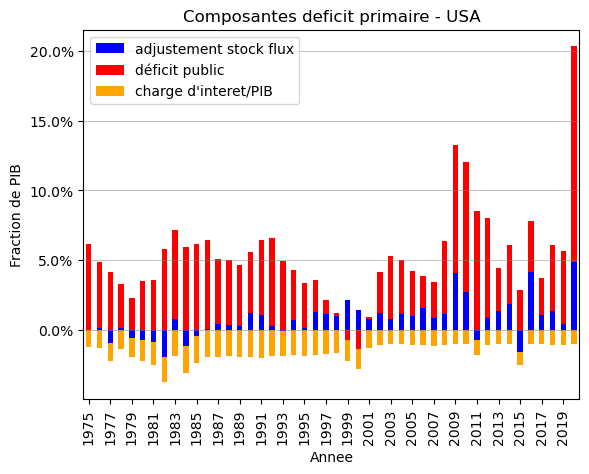

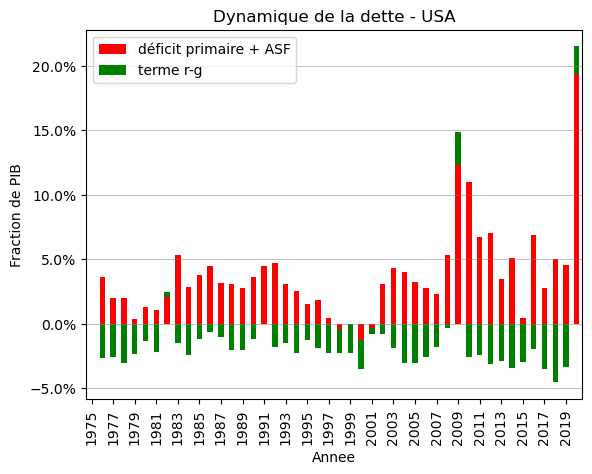

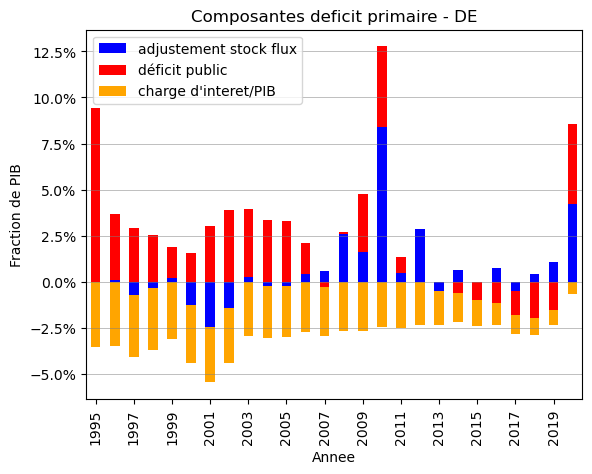

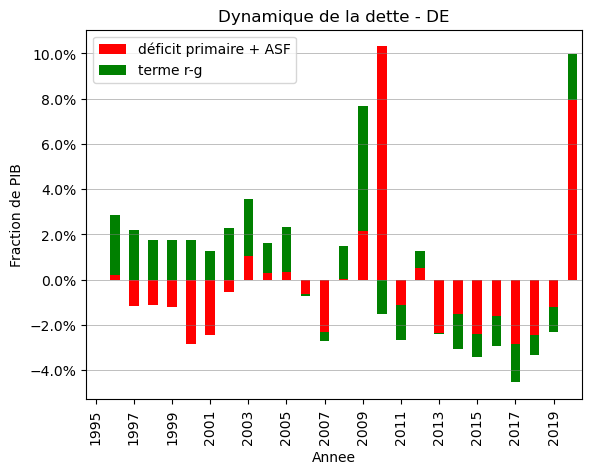

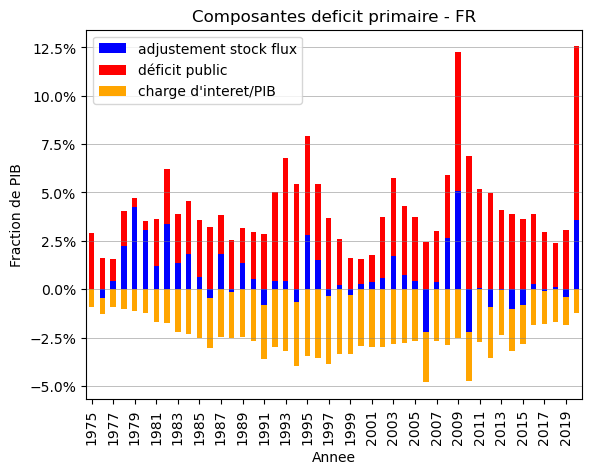

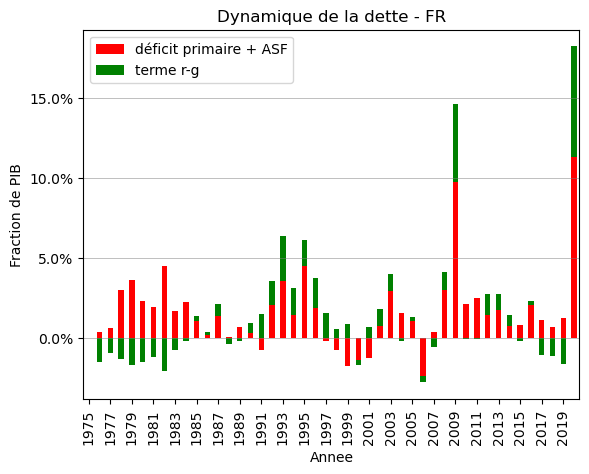

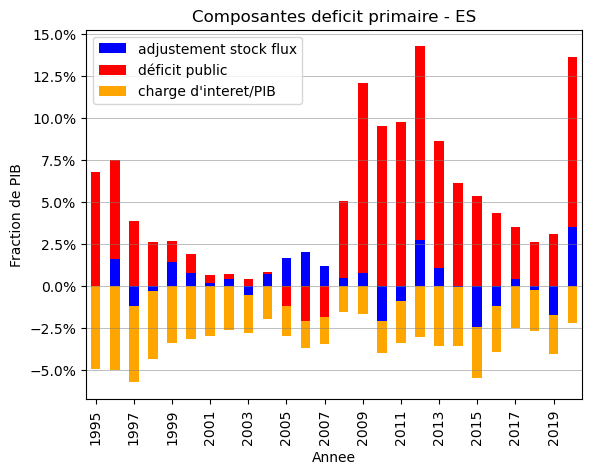

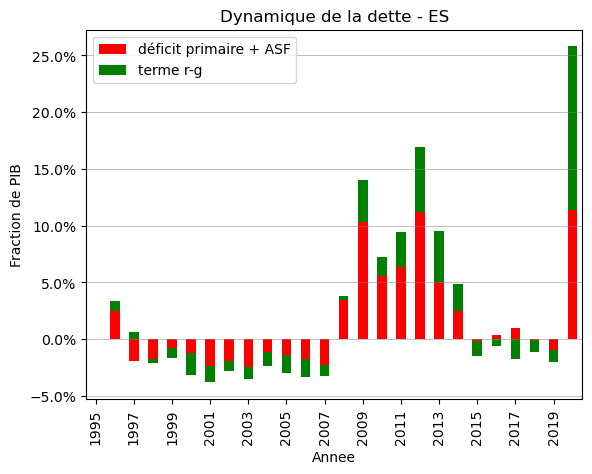

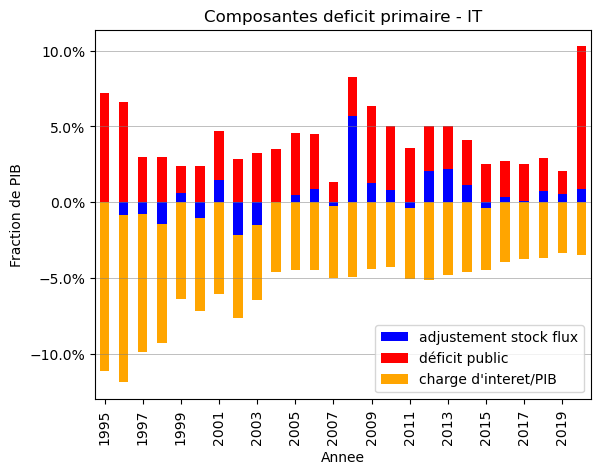

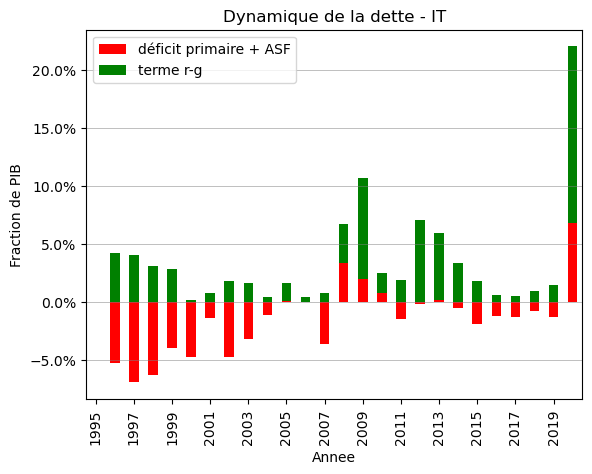

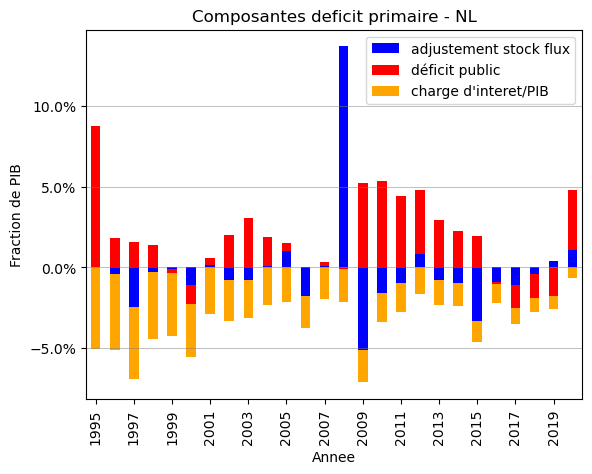

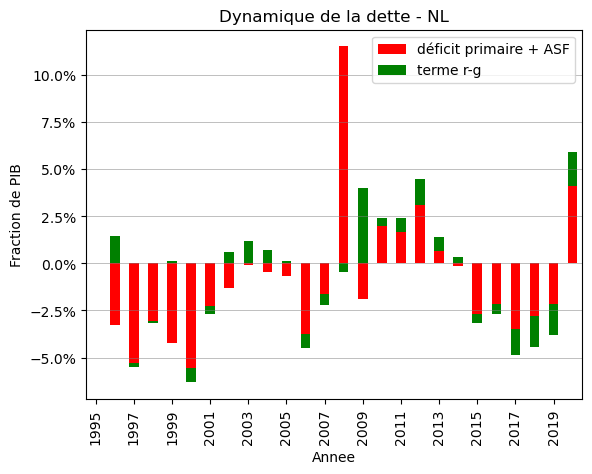

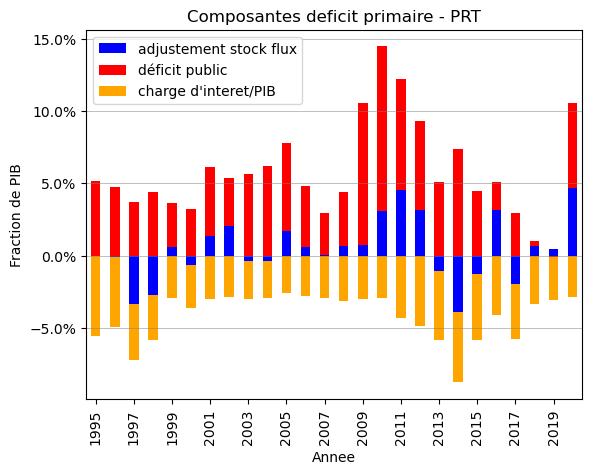

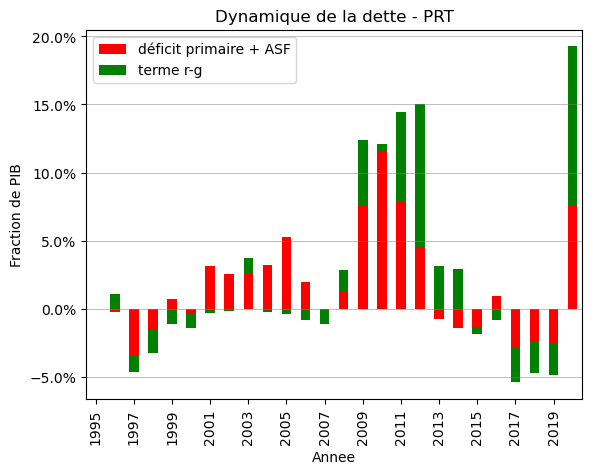

In [87]:
# List of country codes
countries = ['USA','DE', 'FR', 'ES', 'IT', 'NL', 'PRT']

# Process data and plot for each country
for country in countries:
    df = process_country_data(country)
    globals()[f'df_{country}'] = df  # Create DataFrame variable for each country
    plot_data(df, country)

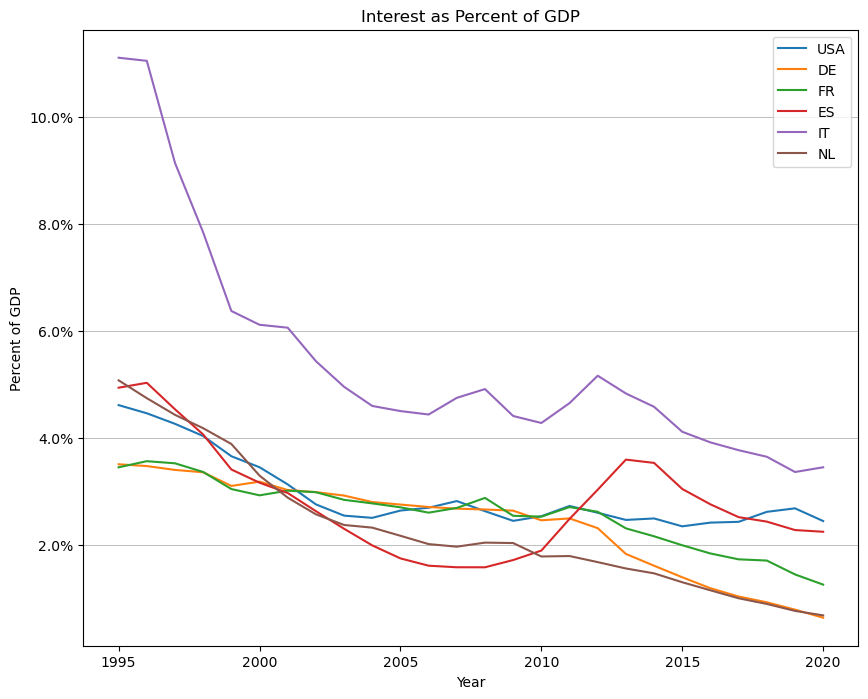

In [64]:
plt.figure(figsize=(10, 8))  # Set the figure size for better readability

ax = None  # Initialize ax for later use
for country in countries:
    # Filter the dataframe to include only the years from 1995 onwards
    df_filtered = globals()[f'df_{country}'][(globals()[f'df_{country}'].index >= 1995)]
    
    # Plot the negative interest percent of GDP
    ax = (-df_filtered['interest Percent of GDP']).plot(label=country)

plt.legend()

# Adding horizontal grey lines across the plot for better readability
ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)

# Set y-axis formatter to percentage
ax.yaxis.set_major_formatter(PercentFormatter(100.0))

plt.title('Interest as Percent of GDP')
plt.xlabel('Year')
plt.ylabel('Percent of GDP')
#plt.savefig('Interest_GDP.png')
plt.show()
plt.close()

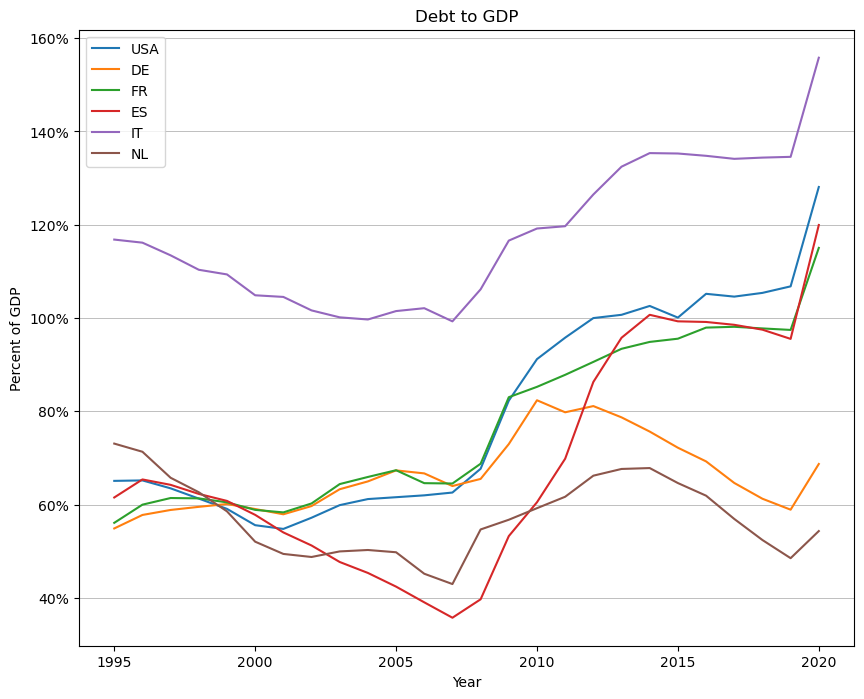

In [65]:
plt.figure(figsize=(10, 8))  # Set the figure size for better readability

ax = None  # Initialize ax for later use
for country in countries:
    # Filter the dataframe to include only the years from 1995 onwards
    df_filtered = globals()[f'df_{country}'][(globals()[f'df_{country}'].index >= 1995)]
    
    # Plot the negative interest percent of GDP
    ax = (df_filtered['debt to GDP']).plot(label=country)

plt.legend()

# Adding horizontal grey lines across the plot for better readability
ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)

# Set y-axis formatter to percentage
ax.yaxis.set_major_formatter(PercentFormatter(100.0))

plt.title('Debt to GDP')
plt.xlabel('Year')
plt.ylabel('Percent of GDP')
#plt.savefig('PercentGDP.png')
plt.show()
plt.close()